In [1]:
import json
from sqlalchemy import select
from sqlalchemy.orm import subqueryload
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from sqlalchemy_bigquery import WKT
import warnings

warnings.filterwarnings("ignore")

from src.database.models import *
from src.database.base import *

In [12]:
s = AsyncSessionMaker()
with open("areas.json", encoding="utf8") as f:
    data = json.load(f)
cities = []
losses = []
i = 1
skip = 17
cnt = skip + 1
LIMIT = 5
for d in data:
    result = await s.execute(select(Region).where(Region.name == d["name"]))
    r = result.scalar()
    for c in d["areas"]:
        try:
            name: str = c["name"]
            PLACE_NAME = f"{name}, {r.name}"
            name = name.split("(")[0].strip()
            city = ox.geocode_to_gdf(PLACE_NAME, which_result=1)
            loc = WKT(city.centroid[0].wkt)
            geometry = WKT(city.geometry[0].wkt)
            cities.append(
                City(
                    region=r,
                    geometry=geometry,
                    type=city["type"][0],
                    name=name,
                    display_name=city.display_name[0],
                    importance=city.importance[0],
                    location=loc,
                    north=city.bbox_north[0],
                    south=city.bbox_south[0],
                    east=city.bbox_east[0],
                    west=city.bbox_west[0],
                )
            )
            print(i, PLACE_NAME)
            i += 1
        except:
            losses.append(PLACE_NAME)

s.add_all(cities)
# s.add_all([City(name="Москва"), City(name="Санкт-Петербург"), City(name="Севастополь")])

await s.commit()

print(losses)

1 Красная Слобода, Нижегородская область
[]


In [ ]:
s = AsyncSessionMaker()
result = await s.execute(select(City).where(City.id == 6583))
city = result.scalar()
city_osm = ox.geocode_to_gdf(["W33722607"], by_osmid=True, which_result=1)
city.location = WKT(city_osm.centroid[0].wkt)
city.geometry = WKT(city_osm.geometry[0].wkt)
city.type = city_osm["type"][0]
city.display_name = city_osm.display_name[0]
city.importance = city_osm.importance[0]
city.north = city_osm.bbox_north[0]
city.south = city_osm.bbox_south[0]
city.east = city_osm.bbox_east[0]
city.west = city_osm.bbox_west[0]

city_osm
s.add(city)
await s.commit()

In [ ]:
s = AsyncSessionMaker()
result = await s.execute(
    select(City).where(City.type == "river").options(subqueryload(City.region))
)
cities = result.scalars()
c_n = []
i = 1
for city in cities:
    PLACE_NAME = f"{city.name} village, {city.region.name}"
    city_osm = ox.geocode_to_gdf(PLACE_NAME, which_result=1)
    city.location = WKT(city_osm.centroid[0].wkt)
    city.geometry = WKT(city_osm.geometry[0].wkt)
    city.type = city_osm["type"][0]
    city.display_name = city_osm.display_name[0]
    city.importance = city_osm.importance[0]
    city.north = city_osm.bbox_north[0]
    city.south = city_osm.bbox_south[0]
    city.east = city_osm.bbox_east[0]
    city.west = city_osm.bbox_west[0]
    c_n.append(city)
    print(i, city)
    i += 1
s.add(city)
await s.commit()

In [10]:
s = AsyncSessionMaker()
with open("loses.json", encoding="utf8") as f:
    data = json.load(f)

cities = []
i = 1
for d in data:
    city_name, region_name = d["name"].split(", ")
    name = city_name.split("(")[0].strip()

    result = await s.execute(select(Region).where(Region.name == region_name))
    r = result.scalar()

    city = ox.geocode_to_gdf([d["id"]], by_osmid=True, which_result=1)
    loc = WKT(city.centroid[0].wkt)
    geometry = WKT(city.geometry[0].wkt)
    cities.append(
        City(
            region=r,
            geometry=geometry,
            type=city["type"][0],
            name=name,
            display_name=city.display_name[0],
            importance=city.importance[0],
            location=loc,
            north=city.bbox_north[0],
            south=city.bbox_south[0],
            east=city.bbox_east[0],
            west=city.bbox_west[0],
        )
    )
    print(i, city_name, region_name)
    i += 1

cities
s.add_all(cities)
await s.commit()

1 Новое Шигалиево Республика Татарстан
2 Поселок Бирюлинского Зверосовхоза Республика Татарстан
3 Поселок станции Каратун Республика Татарстан
4 Агинское (Забайкальский АО) Забайкальский край
5 Селендум Республика Бурятия
6 Сылгы-Ыытар Республика Саха (Якутия)
7 Вершиина Тёи Республика Хакасия
8 посёлок Память Парижской Коммуны Нижегородская область
9 Рабочий поселок им. Степана Разина Нижегородская область
10 Старобокино Рязанская область
11 Артемово Донецкая область
12 Володарское (Донецкая область) Донецкая область
13 Тельманово Донецкая область
14 Колывань Алтайский край
15 Манжерок Алтайский край
16 Нижнеозерное Алтайский край
17 Нижнечуманка Алтайский край
18 Арлюк Кемеровская область
19 Старощербаково Новосибирская область
20 Десеновское Московская область
21 Дмитриевское Тульская область
22 Знамя Октября Московская область
23 Коммунарка Московская область
24 Красная Пахра Московская область
25 Крутченская Байгора Липецкая область
26 Давыдово Московская область
27 Демихово Моско

In [3]:
region = ox.geocode_to_gdf(["R108082"], by_osmid=True, which_result=1)
region

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((36.53049 45.19920, 36.53270 45.18379...",47.003022,43.22443,41.74398,36.530486,214385146,relation,108082,45.768401,39.026104,boundary,administrative,8,0.614468,state,Krasnodar Krai,"Krasnodar Krai, Southern Federal District, Russia"


In [ ]:
s = AsyncSessionMaker()
result = await s.execute(select(Region))
regions = result.scalars()
loses = []
i = 1
for r in regions:
    try:
        region = ox.geocode_to_gdf(r.name, which_result=1)
        r.location = WKT(region.centroid[0].wkt)
        r.geometry = WKT(region.geometry[0].wkt)
        r.type = region["type"][0]
        r.display_name = region.display_name[0]
        r.importance = region.importance[0]
        r.north = region.bbox_north[0]
        r.south = region.bbox_south[0]
        r.east = region.bbox_east[0]
        r.west = region.bbox_west[0]
        print(i, r.name)
        i += 1
    except:
        loses.append(r.id)
s.add_all(regions)
await s.commit()
loses

In [10]:
s = AsyncSessionMaker()
result = await s.execute(select(Region).where(Region.id == 60))
r = result.scalar()

region = ox.geocode_to_gdf(["R77687"], by_osmid=True, which_result=1)
r.location = WKT(region.centroid[0].wkt)
r.geometry = WKT(region.geometry[0].wkt)
r.type = region["type"][0]
r.display_name = region.display_name[0]
r.importance = region.importance[0]
r.north = region.bbox_north[0]
r.south = region.bbox_south[0]
r.east = region.bbox_east[0]
r.west = region.bbox_west[0]

s.add(r)
await s.commit()

In [5]:
import requests
from time import sleep

s = AsyncSessionMaker()
result = await s.execute(select(City).where(City.id.in_([8876, 8877, 8878])))
cities = result.scalars()
url = "https://api.openchargemap.io/v3/poi/?client=ocm.app.ionic.8.5.7&verbose=false&output=json&includecomments=true&maxresults=1000&compact=true&boundingbox="
all_charges = {}
payload = {}
headers = {"X-Api-Key": "9bb03e5b-0fb2-4916-9b2b-26c6bd27a56a"}
i = 1
for c in cities:
    response = requests.get(
        f"{url}({c.south},{c.west}),({c.north},{c.east})",
        headers=headers,
        data=payload,
    )
    charges = response.json()
    sleep(1)
    for charge in charges:
        all_charges[charge["ID"]] = charge
    print(i, c.name)
    i += 1
with open("all_charges_fc.json", "w", encoding="utf-8") as file:
    json.dump(all_charges, file, ensure_ascii=False)

1 Севастополь


In [7]:

from copy import copy
from sqlalchemy import select, func, Boolean, text
from geoalchemy2.shape import from_shape
from shapely.geometry import Point

session = AsyncSessionMaker()
i = 0
with open("proccessed_charges.json", encoding="utf8") as f:
    data = json.load(f)
loses = []
evs=[]
for v in data:
    p = Point(v['address']["Longitude"], v["address"]["Latitude"])
    ev = EVStation(
        cost=v["cost"],
        location=WKT(p.wkt),
        address=v["address"],
        operator=v["operator"],
        data_provider=v["data_provider"],
        usage_type=v["usage_type"],
        сonnections={'сonnections':v["connections"]},
        status_type=v["status_type"],
        submission_status_type=v["submission_status_type"],
        number_points=v["number_points"],
        external_id=v["external_id"],
    )

    stmt = (
        select(City).filter(func.ST_Intersects(City.geometry, from_shape(p))).limit(1)
    )
    result = await session.execute(stmt)
    city = result.scalar_one_or_none()
    if city:
        ev.city = city
        ev.region_id = city.region_id
        evs.append(ev)
        i += 1
    else:
        stmt = (
            select(Region)
            .filter(func.ST_Intersects(Region.geometry, from_shape(p)))
            .limit(1)
        )
        result = await session.execute(stmt)
        region = result.scalar_one_or_none()
        if region:
            ev.region = region
            evs.append(ev)
            i += 1
        else:
            loses.append(v)
print(i)
session.add_all(evs)
await session.commit()
loses
# with open("loses.json", "w", encoding="utf-8") as file:
#     json.dump(loses, file, ensure_ascii=False)

2


[]

In [2]:
from copy import copy
import json

with open("all_charges.json", encoding="utf8") as f:
    data = json.load(f)
all_charges = copy(data)
for k, v in data.items():
    if v["AddressInfo"]["CountryID"] != 185:
        del all_charges[k]
with open("all_charges2.json", "w", encoding="utf-8") as file:
    json.dump(all_charges, file, ensure_ascii=False)

In [6]:
from copy import copy
import json

with open("all_charges.json", encoding="utf8") as f:
    data: dict = json.load(f)

with open("referencedata.json", encoding="utf8") as f:
    ref_data: dict = json.load(f)


def find_item(id: int, key: str):
    for i in ref_data[key]:
        if i["ID"] == id:
            return copy(i)


full_data = []
for k, v in data.items():
    adr = v["AddressInfo"]
    del adr["CountryID"]
    del adr["DistanceUnit"]
    del adr["ID"]

    opr = find_item(v["OperatorID"], "Operators")
    d_p = find_item(v["DataProviderID"], "DataProviders")
    u_t = None
    if "UsageTypeID" in v:
        u_t = find_item(v["UsageTypeID"], "UsageTypes")
    s_t = find_item(v["StatusTypeID"], "StatusTypes")
    sub_t = find_item(v["SubmissionStatusTypeID"], "SubmissionStatusTypes")

    connections = []
    for c in v["Connections"]:
        c_t = find_item(c["ConnectionTypeID"], "ConnectionTypes")
        cs_t = None
        if "StatusTypeID" in c:
            cs_t = find_item(c["StatusTypeID"], "StatusTypes")
        l_d = None
        if "LevelID" in c:
            l_d = find_item(c["LevelID"], "ChargerTypes")
        cur_t = None
        if "CurrentTypeID" in c:
            cur_t = find_item(c["CurrentTypeID"], "CurrentTypes")

        connections.append(
            {
                "quantity": c.get("Quantity", None),
                "current_type": cur_t,
                "power_kw": c.get("PowerKW", None),
                "charger_type": l_d,
                "status_type": cs_t,
                "connection_type": c_t,
            }
        )

    f_d = {
        "cost": v.get("UsageCost", None),
        "location": {
            "lat": v["AddressInfo"]["Latitude"],
            "lon": v["AddressInfo"]["Longitude"],
        },
        "address": adr,
        "operator": opr,
        "data_provider": d_p,
        "usage_type": u_t,
        "status_type": s_t,
        "submission_status_type": sub_t,
        "external_id": {"id": v["ID"], "uuid": v["UUID"]},
        "number_points": v.get("NumberOfPoints"),
        "connections": connections,
    }
    full_data.append(f_d)

with open("proccessed_charges.json", "w", encoding="utf-8") as file:
    json.dump(full_data, file, ensure_ascii=False)

In [11]:
from time import sleep
import requests
import json

KEY = "56586a14-c6fd-4ae3-8ac9-d31c2fce1c8b"
YOUR_API_KEY = "47a5dc24-5c50-476e-8e59-1f8a2993fd73"

text = "Иркутск, парковки"
features = []

MAX_RES = 500
i = 0
while True:
    url = f"https://search-maps.yandex.ru/v1/?text={text}&type=biz&lang=ru_RU&results={MAX_RES}&skip={i}&apikey={YOUR_API_KEY}"
    res = requests.get(url)
    if res.status_code == 200:
        data = res.json()
        i += 500
        for f in data["features"]:
            features.append(f)
        sleep(1)
    else:
        break
with open("parking_NN.json", "w", encoding="utf-8") as file:
    json.dump({"features": features}, file, ensure_ascii=False)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from tqdm.auto import tqdm
import shapely.speedups
from shapely import to_wkt, from_wkt

shapely.speedups.enable()
import warnings

warnings.filterwarnings("ignore")

c:\Users\mrvay\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mrvay\AppData\Local\Temp\ipykernel_8576\729090869.py:13: DeprecationWarning: This function has no longer any effect, and will be removed in a future release. Starting with Shapely 2.0, equivalent speedups are always available
  shapely.speedups.enable()


In [2]:
PLACE_NAME = "Иркутск, Россия"
grid_size = 1000

In [4]:
from shapely.geometry import Point
from shapely.wkt import loads
from shapely import to_wkt
import geodaisy.converters as convert
from shapely import wkt
from geoalchemy2.shape import to_shape
from pyproj import Proj, transform
import json

city_p = ox.geocode_to_gdf(PLACE_NAME)
city = ox.project_gdf(city_p)
geometry = city["geometry"].iloc[0]
geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width=grid_size)
# print(geometry_cut.geoms[0].wkt)
# tags = {
# "amenity": "parking",
# # "amenity": ["parking", "pub", "cafe"],
# # "building": "hotel",
# # "tourism": "hotel",
# }
target = Proj(proj="utm", zone=48, ellps="WGS84")
source = Proj(init="epsg:4326")
# places = ox.geometries_from_place(PLACE_NAME, tags=tags)
ps = []
x_p = []
y_p = []

with open("parking_NN.json", encoding="utf-8") as file:
    data = json.load(file)
parkings = data["features"]

for p in parkings:
    x1 = p["geometry"]["coordinates"][0]
    y1 = p["geometry"]["coordinates"][1]
    x, y = transform(source, target, x1, y1)
    p = Point(x, y)
    x_p.append(x)
    y_p.append(y)
    ps.append(p)

# for place in places.itertuples():
#     try:
#         x, y = transform(source, target, place.geometry.x, place.geometry.y)
#         p = Point(x, y)
#         x_p.append(x)
#         y_p.append(y)
#         ps.append(p)
#     except Exception as e:
#         ...
x = []
y = []
polylist = []
drawed_pols = []
for poly in geometry_cut.geoms:
    # print(poly.wkb_hex)
    # shply_geom = to_shape(poly)
    # p = shapely.wkt.loads(poly.wkt)
    # p = wkt.dumps(p, srid=4326)
    for place in ps:
        if poly.contains(place):
            f = True
            for dp in drawed_pols:
                if dp.contains(poly.centroid):
                    f = False
            if f:
                polylist.append(poly)
                drawed_pols.append(poly)
                x.append(poly.centroid.x)
                y.append(poly.centroid.y)

plt.figure(figsize=(20, 20))
plt.scatter(x, y)
plt.scatter(x_p, y_p, edgecolors="red")
# ax = city.plot()

TypeError: cannot unpack non-iterable Figure object

<Figure size 2000x2000 with 0 Axes>

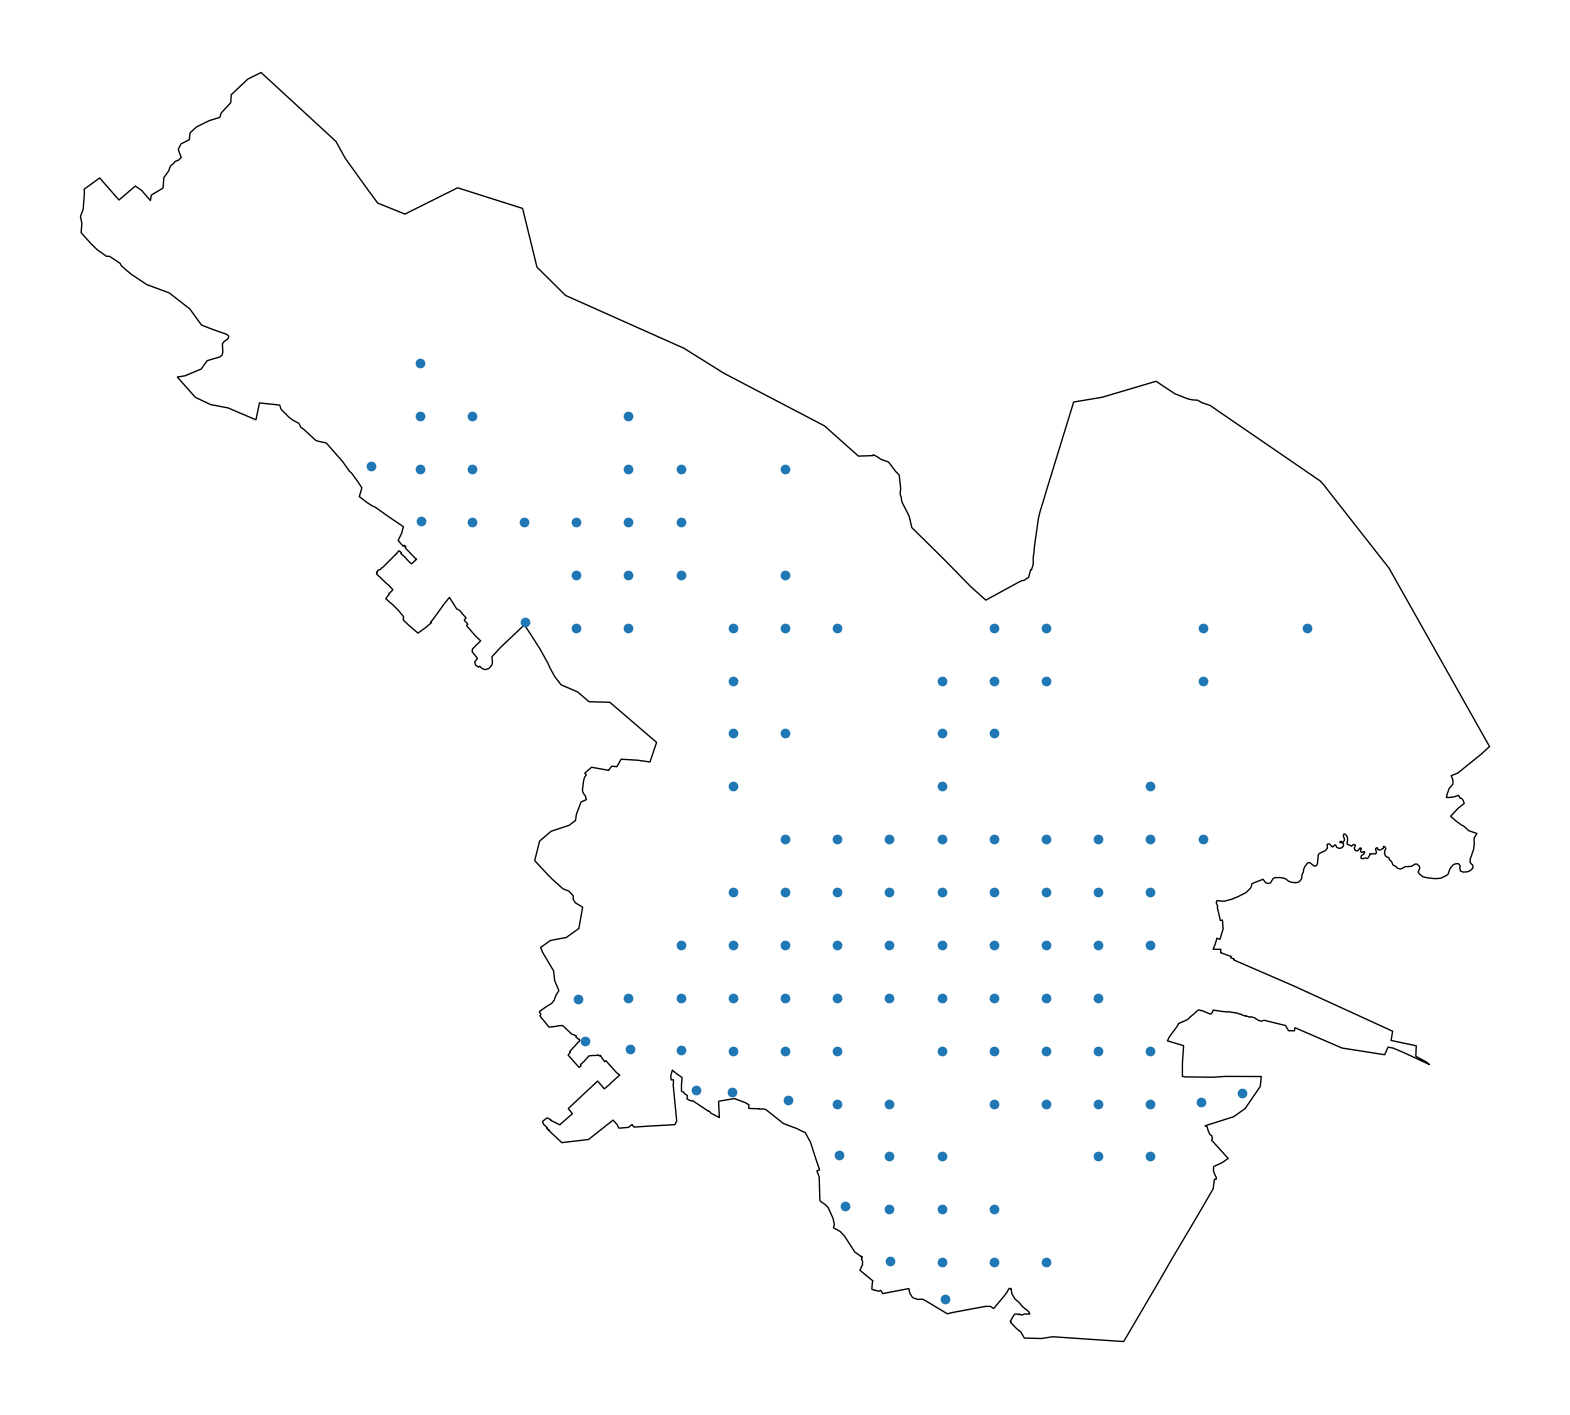

In [5]:
from matplotlib.patches import Rectangle

# D = 0.004
# OF = 0.00005
# M = 1.5
D = 445
OF = 10
M = 1
# xs = []
# ys = []
fig, ax = plt.subplots(figsize=(20, 20))
for poly in polylist:
    # x1, y1 = transform(target, source, poly.centroid.x, poly.centroid.y)

    # xs.append(x1)
    # ys.append(y1)
    x1 = poly.centroid.x
    y1 = poly.centroid.y
    r = Rectangle(
        (x1 - D * M / 2, y1 - D / 2),
        D * M,
        D,
        fc="none",
        ec="#000000",
    )
    ax.add_patch(r)

city.plot(ax=ax, color="none", edgecolor="black")
plt.scatter(x, y)
plt.scatter(x_p, y_p, edgecolors="red")
# ax.set_xlim(west, east)
# ax.set_ylim(south, north)
ax.axis("off")
plt.show()

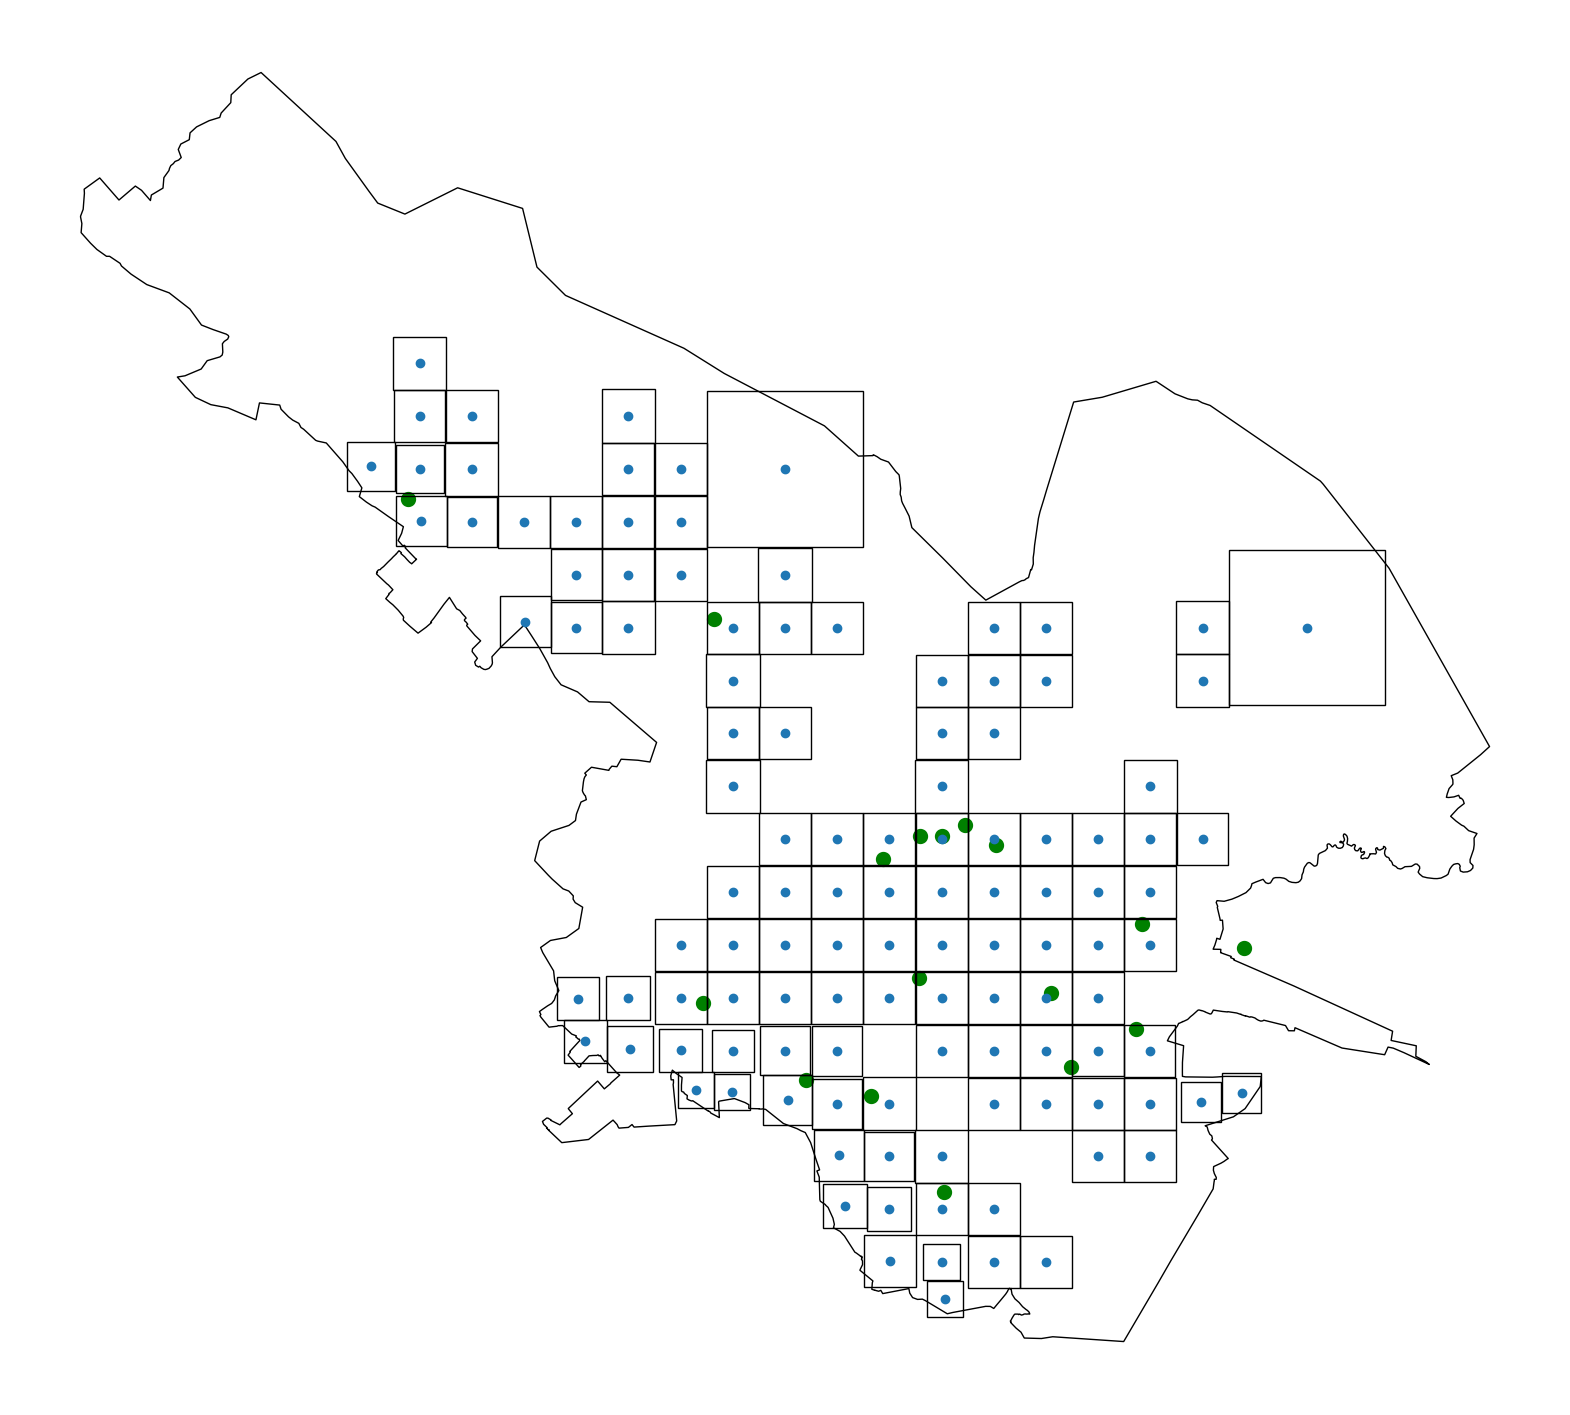

In [17]:
import numpy


def create_poly(poly: dict, size: int = D):
    left_bottom = (poly["centr"].x - size * M / 2, poly["centr"].y - size / 2)
    left_top = (left_bottom[0], left_bottom[1] + size)
    right_top = (left_top[0] + size * M, left_top[1])
    right_bottom = (right_top[0], right_top[1] - size)
    coords = (left_bottom, left_top, right_top, right_bottom)
    return shapely.Polygon(coords)


xs = []
ys = []

with open("proccessed_charges.json", encoding="utf-8") as file:
    charges = json.load(file)

with open("ev_load.json", encoding="utf-8") as file:
    data = json.load(file)
stations = data["stations"]
x_ch = []
y_ch = []
сhs = []
for s in stations:
    f_s = None
    values = []
    for c in charges:
        a = c["address"]
        if a["Title"] == s["name"]:
            f_s = a
            break
    if f_s:
        x1, y1 = transform(source, target, f_s["Longitude"], f_s["Latitude"])
        average = 0
        for w in s["weekdays"].values():
            for k, v in w.items():
                values.append(v)
        сhs.append({"p": Point(x1, y1), "average": numpy.median(values)})
        x_ch.append(x1)
        y_ch.append(y1)


def draw(data_pols: list[dict]):
    for poly in data_pols:
        xs.append(poly["centr"].x)
        ys.append(poly["centr"].y)

        r = Rectangle(
            (poly["centr"].x - poly["d"] * M / 2, poly["centr"].y - poly["d"] / 2),
            poly["d"] * M,
            poly["d"],
            fc="none",
            ec="#000000",
        )
        ax.add_patch(r)

    city.plot(ax=ax, color="none", edgecolor="black")
    plt.scatter(xs, ys)
    plt.show()


data_pols = []

for poly in polylist:
    d = {}
    # x1, y1 = transform(target, source, poly.centroid.x, poly.centroid.y)

    x1 = poly.centroid.x
    y1 = poly.centroid.y
    d["centr"] = Point(x1, y1)
    d["change"] = True
    d["d"] = D
    d["poly"] = create_poly(d)

    data_pols.append(d)


fig, ax = plt.subplots(figsize=(20, 20))
f = True
while f:
    f = False
    for i in range(len(data_pols)):
        p = data_pols[i]
        if not p["change"]:
            continue
        size = p["d"] + OF
        new_poly = create_poly(p, size)
        can_change = True
        for j in range(len(data_pols)):
            if i != j and data_pols[j]["poly"].intersects(new_poly):
                can_change = False
                break
        if can_change:
            f = True
            p["d"] = size
            p["poly"] = new_poly
        else:
            p["change"] = False
# plt.scatter(x_p, y_p, c="r")
ax.axis("off")
plt.scatter(x_ch, y_ch, c="g", linewidths=5)
draw(data_pols)

Точка (441416.7730385547, 5800923.955287463) классифицирована как 16
Точка (442331.1005020782, 5802858.2331636455) классифицирована как 16
Точка (442331.10050207813, 5801866.398713948) классифицирована как 16
Точка (442331.1005020782, 5800874.564264251) классифицирована как 16
Точка (442364.10001797526, 5799903.038359914) классифицирована как 16
Точка (443310.0337931805, 5801866.398713948) классифицирована как 16
Точка (443310.03379318054, 5800874.564264251) классифицирована как 16
Точка (443310.03379318054, 5799882.729814555) классифицирована как 16
Точка (444288.96708428295, 5799882.729814555) классифицирована как 16
Точка (444311.2310164659, 5798008.91541561) классифицирована как 16
Точка (445267.90037538536, 5799882.729814555) классифицирована как 15
Точка (445267.90037538536, 5798890.895364858) классифицирована как 15
Точка (445267.90037538536, 5797899.060915162) классифицирована как 15
Точка (446246.83366648783, 5801866.398713948) классифицирована как 15
Точка (446246.8336664878,

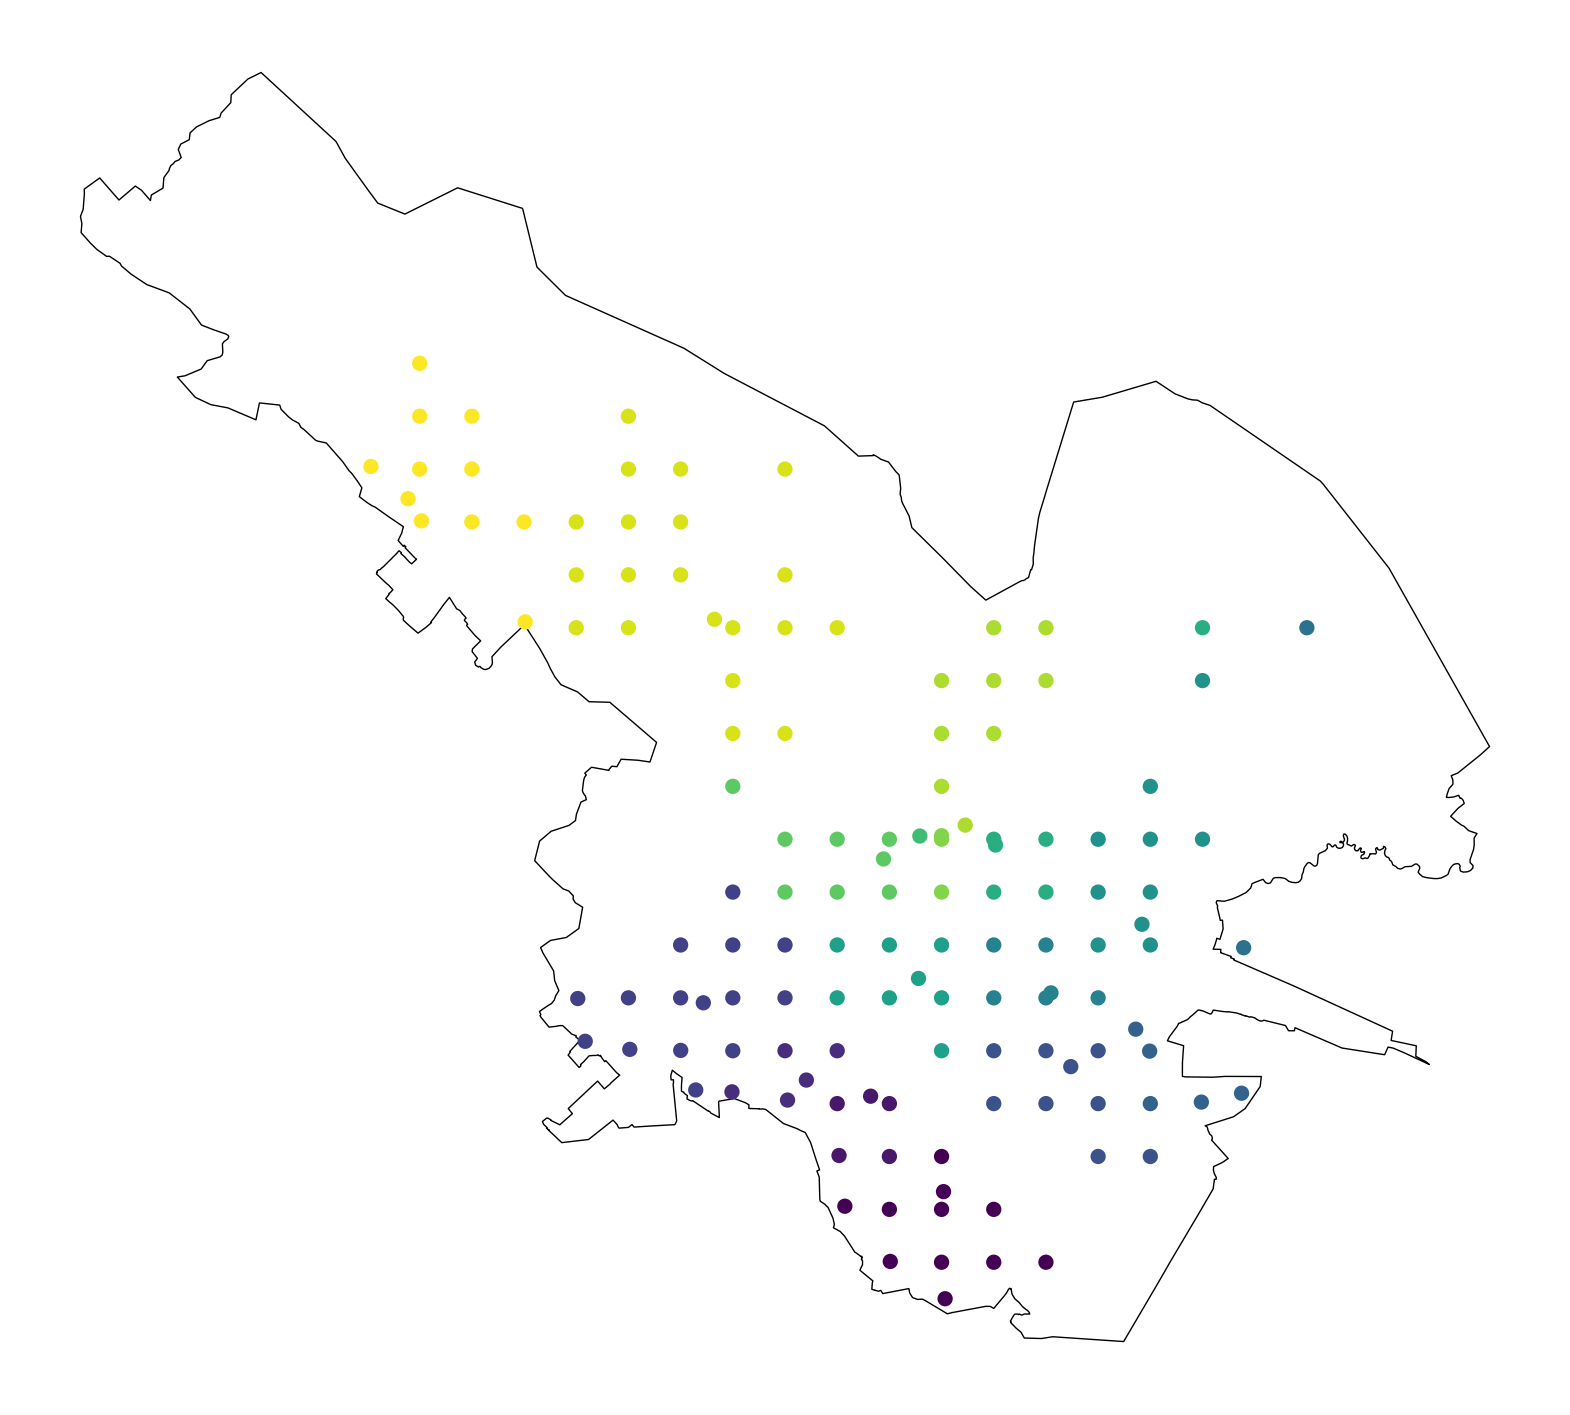

In [23]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

fig, ax = plt.subplots(figsize=(20, 20))

# Заданные классифицированные точки (координаты и класс)
classified_points = []
for i in range(len(сhs)):
    ch = сhs[i]
    classified_points.append((ch["p"].x, ch["p"].y, i))

# Неклассифицированные точки (координаты)
unclassified_points = []
for d in data_pols:
    unclassified_points.append((d["centr"].x, d["centr"].y))

# Создание массивов для хранения координат и меток классов
X_train = np.array(
    [point[:2] for point in classified_points]
)  # Координаты классифицированных точек
y_train = np.array(
    [point[2] for point in classified_points]
)  # Метки классов классифицированных точек

X_test = np.array(unclassified_points)  # Координаты неклассифицированных точек

# Создание и обучение модели классификации методом k-ближайших соседей
knn = KNeighborsClassifier(n_neighbors=1)  # Используем только одного ближайшего соседа
knn.fit(X_train, y_train)

# Предсказание меток классов неклассифицированных точек
predicted_labels = knn.predict(X_test)

x = [c[0] for c in classified_points]
y = [c[1] for c in classified_points]
c = [c[2] for c in classified_points]

# Вывод результатов
for point, label in zip(unclassified_points, predicted_labels):
    print("Точка", point, "классифицирована как", label)
    x.append(point[0])
    y.append(point[1])
    c.append(label)

city.plot(ax=ax, color="none", edgecolor="black")
ax.axis("off")
plt.scatter(x, y, c=c, linewidths=5)
plt.show()

In [56]:
import osmnx as ox
import json
import numpy as np
import shapely
import requests
URL = "http://46.243.226.43:8000"
tags = {"amenity": "parking"}

In [63]:
offset = 0

while True:
    response = requests.get(
        f"{URL}/geo/cities/all?limit=100&offset={offset}",
    )
    if response.status_code == 404:
        break
    response_json = response.json()
    for i in response_json['items']:
        try:
            city_id = i['id']
            city_name = i['name']
            places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
            geometry_array = np.array(places['geometry'].tolist())
            to_json = []

            for g in geometry_array:
                point = g.centroid if type(g) == shapely.geometry.polygon.Polygon else g
                to_json.append({'x': point.x, 'y': point.y})

            with open(f"dataset_parking/{city_id}.json", "w") as f:
                json.dump(to_json, f)
        except Exception as e:
            continue
    offset += 1
    print('here')



C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
c:\Users\maksi\.virtualenvs\backend-zJMeRJnk\lib\site-packages\osmnx\features.py:1034: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

here


C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  places = ox.geometries_from_place(f"{city_name}, Россия", tags=tags, which_result=1)
C:\Users\maksi\AppData\Local\Temp\ipykernel_11920\2586829954.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `feat

KeyboardInterrupt: 